In [1]:
!pip -q install torch-geometric
#taken from the pytorch Geometric Repo
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.8.0+${CUDA}.html
#one of the packages below that need rdkit to run
!pip -q install rdkit
!pip3 install torch torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.8.0+.html
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 53.0 MB/s eta 0:00:00


In [2]:
#GETTING DATA AND INITIAL CHECKS
import torch
from torch_geometric.datasets import MoleculeNet

dataset = MoleculeNet(root="moleculenet", name="ESOL")
print(dataset)
print("Num_graphs-->", len(dataset))
print("Num_node_features-->", dataset.num_features)

Processing...


ESOL(1128)
Num_graphs--> 1128
Num_node_features--> 9


Done!


In [3]:
#DATA ANALYSIS
from torch_geometric import edge_index
data = dataset[0]
print(data)
print("""       \n note that edge index has row shape of 2 (one for edge source and edge destination),
        edge attr also has 3 rows, from my research, the rows correspond to bond_type, conjugation
        and ring membership """)
print("""       WIKIPEDIA PAGE FOR SMILES NOTATION (A QUICK SKIM THRU IT IS RECOMMENDED): \n
        https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System \n""")
print("num_nodes-->", data.num_nodes)
print("num_egdes --> ", data.num_edges)
print("x_shape--> ", tuple(data.x.shape))
print("edge_index shape--> ", tuple(data.edge_index.shape))
print("edge_attr shape--> ", None if data.edge_attr is None else tuple(data.edge_attr.shape))
print("y -->", data.y, "shape-->", tuple(data.y.shape))

print("\n\n")

print(data.edge_index)


Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ', y=[1, 1])
       
 note that edge index has row shape of 2 (one for edge source and edge destination),
        edge attr also has 3 rows, from my research, the rows correspond to bond_type, conjugation
        and ring membership 
       WIKIPEDIA PAGE FOR SMILES NOTATION (A QUICK SKIM THRU IT IS RECOMMENDED): 

        https://en.wikipedia.org/wiki/Simplified_Molecular_Input_Line_Entry_System 

num_nodes--> 32
num_egdes -->  68
x_shape-->  (32, 9)
edge_index shape-->  (2, 68)
edge_attr shape-->  (68, 3)
y --> tensor([[-0.7700]]) shape--> (1, 1)



tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  6,  6,  7,  7,  7,
          8,  8,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 13, 14, 14, 14, 15, 15,
         16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 20, 21, 22, 22, 22, 23, 24, 24,
         24, 25, 26, 26, 26, 27, 28, 28, 28, 29, 30, 30, 30, 31],
        [ 1,  0,

In [4]:
#GETTING THE IUPAC NAMES OF THE MOLECULES
import requests
from urllib.parse import quote

smiles = data.smiles
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/{quote(smiles)}/property/IUPACName,Title/JSON"
r = requests.get(url, timeout=30)
r.raise_for_status()

props = r.json()["PropertyTable"]["Properties"][0]
print("PubChem Title --> ", props.get("Title"))
print("IUPAC Name-->", props.get("IUPACName"))


PubChem Title -->  2-Phenyl-2-(3,4,5-Trihydroxy-6-((3,4,5-Trihydroxy-6-(Hydroxymethyl)Oxan-2-Yl)Oxymethyl)Oxan-2-Yl)Oxyacetonitrile
IUPAC Name--> 2-phenyl-2-[3,4,5-trihydroxy-6-[[3,4,5-trihydroxy-6-(hydroxymethyl)oxan-2-yl]oxymethyl]oxan-2-yl]oxyacetonitrile


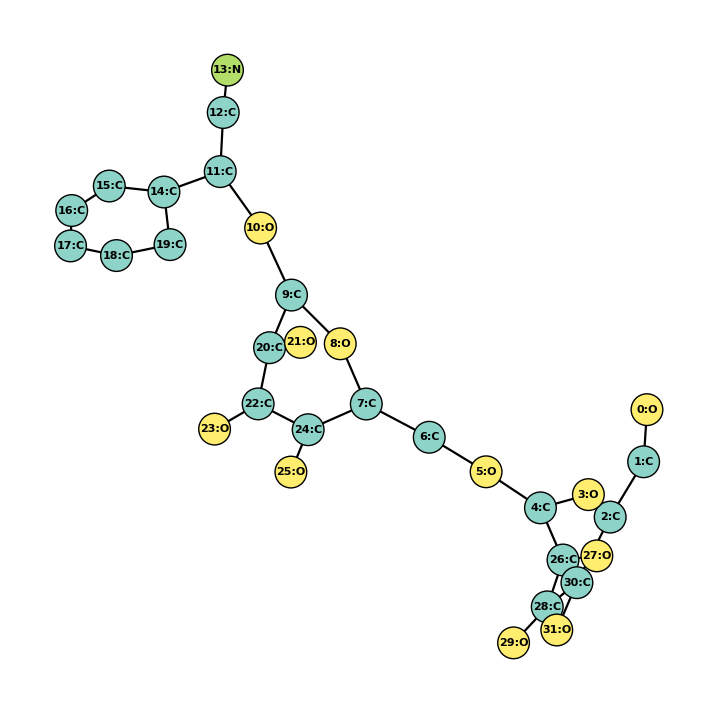

In [5]:
# VISUALISING ONE OF THE MOLECULES
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from rdkit import Chem
from collections import Counter
from networkx.drawing.nx_agraph import graphviz_layout


mol = Chem.MolFromSmiles(data.smiles)
symbols = [a.GetSymbol() for a in mol.GetAtoms()]
G = to_networkx(data, to_undirected=True)


pos = nx.spring_layout(G, seed=0, k=1.2, iterations=300)
# https://en.wikipedia.org/wiki/Force-directed_graph_drawing
# "Force-directed graph drawing algorithms are a class of algorithms
# for drawing graphs in an aesthetically-pleasing way."--> wikipedia

elts = sorted(set(symbols))
element_to_id = {e:i for i,e in enumerate(elts)}
node_group = [element_to_id[s] for s in symbols]

plt.figure(figsize=(9, 9), dpi=100)
nx.draw_networkx_nodes(
    G, pos,
    node_color=node_group,
    cmap=plt.cm.Set3,
    node_size=520,
    edgecolors="black",
    linewidths=1.0
)
nx.draw_networkx_edges(G, pos, width=1.6)

labels = {i: f"{i}:{symbols[i]}" for i in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_weight="bold")

plt.axis("off")
plt.show()


num_node_features--> 9
has_smiles--> True
Atoms per molecule--> {'min': 1, 'mean': 13.289893617021276, 'median': 12.0, 'max': 55}
Bonds per molecule --> {'min': 0, 'mean': 13.677304964539006, 'median': 12.0, 'max': 62}


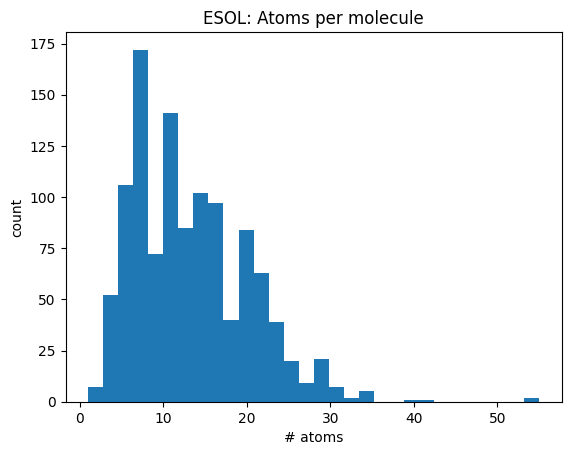

In [6]:
#AVERAGE NUMBER OF ATOMS AND BONDS PER MOLECULES..
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
import numpy as np
print("num_node_features-->", dataset.num_features)
print("has_smiles-->", hasattr(dataset, "smiles"))

num_atoms = np.array([dataset[i].num_nodes for i in range(len(dataset))])

# In PyG, bonds are often stored as directed edges (A to B and B to A).
num_edges = np.array([dataset[i].num_edges for i in range(len(dataset))])
num_bonds = num_edges // 2

def summary(x):
    return dict(min=int(x.min()), mean=float(x.mean()), median=float(np.median(x)), max=int(x.max()))

print("Atoms per molecule-->", summary(num_atoms))
print("Bonds per molecule -->", summary(num_bonds))

plt.figure()
plt.hist(num_atoms, bins=30)
plt.title("ESOL: Atoms per molecule")
plt.xlabel("# atoms")
plt.ylabel("count")
plt.show()


Any NaNs in y?--> False
NaN count --> 0
y mean --> -3.0501019954681396
y variance --> 4.391169548034668


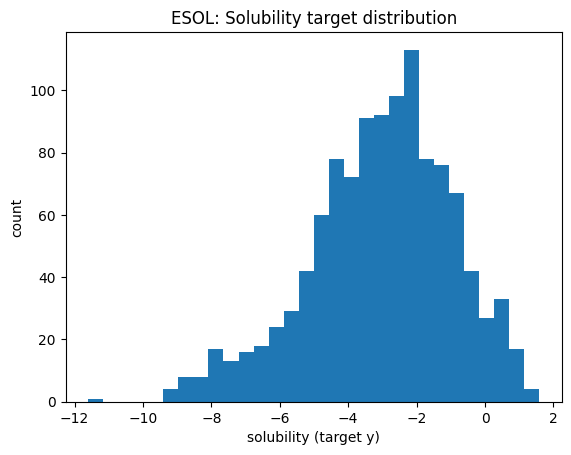

In [7]:
#SOLUBILITY ANALYSIS AND CHECKING IF THE DATA IS COMPLETE
ys = []
for i in range(len(dataset)):
    y = dataset[i].y.view(-1)
    ys.append(y.item())
ys = torch.tensor(ys, dtype=torch.float32)

print("Any NaNs in y?-->", torch.isnan(ys).any().item())
print("NaN count -->", torch.isnan(ys).sum().item())
print("y mean -->", ys.mean().item())
print("y variance -->", ys.var(unbiased=False).item())

plt.figure()
plt.hist(ys.numpy(), bins=30)
plt.title("ESOL: Solubility target distribution")
plt.xlabel("solubility (target y)")
plt.ylabel("count")
plt.show()


In [8]:
# DATASPLIT, DATALOADING, AND GETTING THE SD AND VAR OF THE DATA
from rdkit.Chem.Scaffolds import MurckoScaffold

#https://www.rdkit.org/docs/source/rdkit.Chem.Scaffolds.MurckoScaffold.html
# https://datagrok.ai/help/datagrok/solutions/domains/chem/scripts/murcko-scaffolds
def scaffold_smiles(smiles: str) -> str:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

smiles_list = dataset.smiles
scaff2idx = {}
for i, smi in enumerate(smiles_list):
    scaf = scaffold_smiles(smi)
    scaff2idx.setdefault(scaf, []).append(i)

# Sort scaffold groups by size (big groups assigned first, standard scaffold split style)
groups = sorted(scaff2idx.values(), key=len, reverse=True)

n = len(dataset)
n_train = int(0.85 * n)
train_idx, test_idx = [], []
for g in groups:
    if len(train_idx) + len(g) <= n_train:
        train_idx += g
    else:
        test_idx += g

train_ds = Subset(dataset, train_idx)
test_ds  = Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)

y_train = torch.tensor([dataset[i].y.item() for i in train_idx], dtype=torch.float32)
y_test  = torch.tensor([dataset[i].y.item() for i in test_idx], dtype=torch.float32)

y_mean = y_train.mean()
test_mse_baseline = ((y_test - y_mean) ** 2).mean()
train_var = y_train.var(unbiased=False)
y_std  = y_train.std(unbiased=False).item() + 1e-8

print("y_mean, y_std:", y_mean, y_std)
print(f"Split sizes -- train: {len(train_idx)} -- test: {len(test_idx)}")
print("Train mean baseline:", y_mean.item())
print("Train variance (population):", train_var.item())
print("Test MSE of mean baseline:", test_mse_baseline.item())
print("Loaders ready:", len(train_loader), "train batches --", len(test_loader), "test batches")


y_mean, y_std: tensor(-2.9044) 2.0691332917077636
Split sizes -- train: 958 -- test: 170
Train mean baseline: -2.904381036758423
Train variance (population): 4.281312465667725
Test MSE of mean baseline: 5.151142597198486
Loaders ready: 15 train batches -- 3 test batches


so in the last cell, I had a question that if we sort it wouldnt that make training a bit more difficult, but apperently that whats desired in computational biology.. training shouldnt too easy for the model... my initial plan was random picking for the train/test split but after some research, I figured out that sorting would be a better option for this task.

In [9]:
#MODEL 1 OF 3
# Graph Convolutional Network
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GraphNorm, global_mean_pool

class GCN_model(nn.Module):
    def __init__(self, in_dim, hidden=32, layers=3, dropout=0.3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = dropout

        self.convs.append(GCNConv(in_dim, hidden))
        self.norms.append(GraphNorm(hidden)) #doesnt need an output
        for _ in range(layers - 1):
            self.convs.append(GCNConv(hidden, hidden))
            self.norms.append(GraphNorm(hidden))

        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        for conv, norm in zip(self.convs, self.norms):
            x = x.float()
            edge_index = edge_index.long()
            #has to be float if not you'll get an error during training
            x = conv(x, edge_index)
            x = norm(x, batch)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        g = global_mean_pool(x, batch)
        return self.head(g).view(-1)



In [10]:
#MODEL 2 OF 3 (THE BEST OF THE 3 MODELS, SO I SPENT MORE TIME FINETUNING THIS)
# https://arxiv.org/pdf/1905.12265
# GINE = Graph Isomorphism Network with Edge features.
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINEConv, GraphNorm, global_mean_pool

class GINE_model(nn.Module):
    def __init__(self, in_dim, edge_dim, hidden=32, layers=2, dropout=0.4):
        super().__init__()
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = dropout

        nn1 = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
        )
        self.convs.append(GINEConv(nn1, edge_dim=edge_dim))
        self.norms.append(GraphNorm(hidden))

        for _ in range(layers - 1):
            nnk = nn.Sequential(
                nn.Linear(hidden, hidden),
                nn.ReLU(),
                nn.Linear(hidden, hidden),
            )
            self.convs.append(GINEConv(nnk, edge_dim=edge_dim))
            self.norms.append(GraphNorm(hidden))

        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1),
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        for conv, norm in zip(self.convs, self.norms):
            x = x.float()
            edge_index = edge_index.long()
            edge_attr = edge_attr.float()
            x = conv(x, edge_index, edge_attr)
            x = norm(x, batch)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        g = global_mean_pool(x, batch)
        return self.head(g).view(-1)


In [11]:
#MODEL 3 OF 3 (MOST COMPUTE INTENSIVE OF THE 3)
#GAT variant (edge aware)
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, GraphNorm, global_mean_pool

class GATv2_model(nn.Module):
    def __init__(self, in_dim, edge_dim, hidden=32, layers=3, heads=4, dropout=0.3):
        super().__init__()
        assert hidden % heads == 0, "hidden must be divisible by heads"
        self.convs = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropout = dropout
        out_per_head = hidden // heads

        # 1) in_dim -> hidden
        self.convs.append(GATv2Conv(in_dim, out_per_head, heads=heads, concat=True,
                                   dropout=dropout, edge_dim=edge_dim))
        self.norms.append(GraphNorm(hidden))

        # 2) hidden -> hidden
        for _ in range(layers - 1):
            self.convs.append(GATv2Conv(hidden, out_per_head, heads=heads, concat=True,
                                       dropout=dropout, edge_dim=edge_dim))
            self.norms.append(GraphNorm(hidden))

        self.head = nn.Sequential(
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1),
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch

        for conv, norm in zip(self.convs, self.norms):
            x = x.float()
            edge_index = edge_index.long()
            edge_attr = edge_attr.float()
            x = conv(x, edge_index, edge_attr)
            x = norm(x, batch)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        g = global_mean_pool(x, batch)
        return self.head(g).view(-1)


# ISSUES DURING AND AFTER TRAINING. 👇
one issue i had to resolve before training was to check the types of the data being passed into the forward pass.. I had quite a lot of datatype issues... ngl, to solve it, i just kept trying long and float to see which one would work.. and when it seemed like the model would run.. i just left it like that.. i might have lost some data though,, not sure (would check l8r). During training, i tried normalising the training data using the mean and variance but it somehow made training worse.. I guessing some of the normalisation in the model (i.e graphNorm) might be alreay normalising the data enough. solubility is also on a logarithmic scale so normalizsing by the SD and mean might not be the best thing to do. Finally, ESOL is a pretty small dataset, (it's bound to overfit)

In [12]:
#TRAINING SNIPPET (Muon hidden convs + AdamW for the rest)
import torch
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_model(name, in_dim, edge_dim=None, hidden=64, layers=4, dropout=0.1, heads=4):
    name = name.lower()
    if name == "gcn":
        return GCN_model(in_dim=in_dim, hidden=hidden, layers=layers, dropout=dropout)
    if name == "gine":
        return GINE_model(in_dim=in_dim, edge_dim=edge_dim, hidden=hidden, layers=layers, dropout=dropout)
    if name == "gatv2":
        return GATv2_model(in_dim=in_dim, edge_dim=edge_dim, hidden=hidden, layers=layers, heads=heads, dropout=dropout)
    raise ValueError("name must be one of: 'gcn', 'gine', 'gatv2'")

def split_muon_adamw(model):
    muon_params, adamw_params = [], []
    for name, p in model.named_parameters():
        # Muon: ONLY hidden message-passing weights (exclude convs.0 = input layer)
        if p.ndim == 2 and name.startswith("convs.") and (not name.startswith("convs.0.")):
            muon_params.append(p)
        else:
            adamw_params.append(p)
    return muon_params, adamw_params

@torch.no_grad()
def eval_mse(model, loader):
    model.eval()
    total_se, total_n = 0.0, 0
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(-1).to(pred.dtype)
        total_se += ((pred - y) ** 2).sum().item()
        total_n += y.numel()
    return total_se / total_n

def train(model_name="gcn", epochs=280, lr_muon=1e-3, lr_adamw=1e-3, weight_decay=1e-2, clip=1.0,
          hidden=64, layers=4, dropout=0.1, heads=4):

    in_dim = dataset.num_features
    edge_dim = dataset[0].edge_attr.size(-1)

    model = make_model(model_name, in_dim=in_dim, edge_dim=edge_dim, hidden=hidden,
                       layers=layers, dropout=dropout, heads=heads).to(device)

    muon_params, adamw_params = split_muon_adamw(model)
    opt_muon = torch.optim.Muon(muon_params, lr=lr_muon, weight_decay=weight_decay)
    opt_adamw = torch.optim.AdamW(adamw_params, lr=lr_adamw, weight_decay=weight_decay)

    history = {"train_mse": [], "test_mse": []}
    pbar = tqdm(range(1, epochs + 1))

    for epoch in pbar:
        model.train()
        total_se, total_n = 0.0, 0

        for batch in train_loader:
            batch = batch.to(device)
            opt_muon.zero_grad()
            opt_adamw.zero_grad()

            pred = model(batch)
            y = batch.y.view(-1).to(pred.dtype)

            loss = ((pred - y) ** 2).mean()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            opt_muon.step()
            opt_adamw.step()

            total_se += ((pred.detach() - y) ** 2).sum().item()
            total_n += y.numel()

        train_mse = total_se / total_n
        test_mse = eval_mse(model, test_loader)

        history["train_mse"].append(train_mse)
        history["test_mse"].append(test_mse)

        pbar.set_postfix(train_mse=f"{train_mse:.4f}", test_mse=f"{test_mse:.4f}")

        if epoch % 20 == 0:
            print(f"[{model_name}] epoch {epoch:3d} -- train_mse={train_mse:.5f} -- test_mse={test_mse:.5f}")

    return model, history

# model, hist = train("gcn", epochs=200)
model, hist = train("gine", epochs=300)
# model, hist = train("gatv2", epochs=200)


  0%|          | 0/300 [00:00<?, ?it/s]

[gine] epoch  20 -- train_mse=2.76767 -- test_mse=4.05119
[gine] epoch  40 -- train_mse=1.22252 -- test_mse=2.80498
[gine] epoch  60 -- train_mse=0.91917 -- test_mse=2.62020
[gine] epoch  80 -- train_mse=0.71054 -- test_mse=2.60463
[gine] epoch 100 -- train_mse=0.63015 -- test_mse=2.22646
[gine] epoch 120 -- train_mse=0.51365 -- test_mse=2.79000
[gine] epoch 140 -- train_mse=0.49041 -- test_mse=2.36305
[gine] epoch 160 -- train_mse=0.41424 -- test_mse=2.36977
[gine] epoch 180 -- train_mse=0.37915 -- test_mse=2.11189
[gine] epoch 200 -- train_mse=0.35866 -- test_mse=2.26418
[gine] epoch 220 -- train_mse=0.33582 -- test_mse=2.35285
[gine] epoch 240 -- train_mse=0.29954 -- test_mse=2.29259
[gine] epoch 260 -- train_mse=0.29498 -- test_mse=1.97212
[gine] epoch 280 -- train_mse=0.29368 -- test_mse=2.12576
[gine] epoch 300 -- train_mse=0.26426 -- test_mse=2.23611


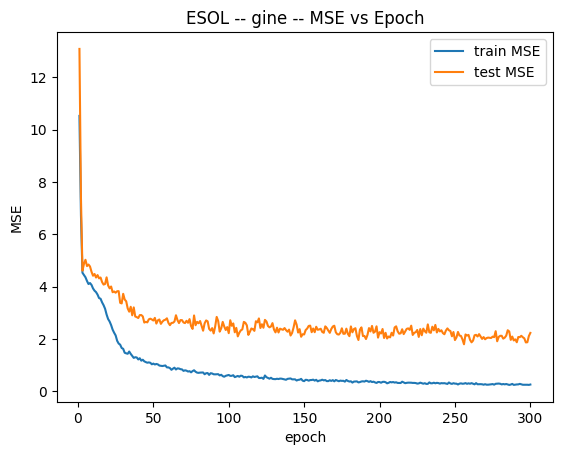

In [13]:
#LOSS CURVE
model_name = "gine"  # change if you trained "gine" or "gatv2"
epochs = np.arange(1, len(hist["train_mse"]) + 1)

plt.figure()
plt.plot(epochs, hist["train_mse"], label="train MSE")
plt.plot(epochs, hist["test_mse"], label="test MSE")
plt.title(f"ESOL -- {model_name} -- MSE vs Epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()


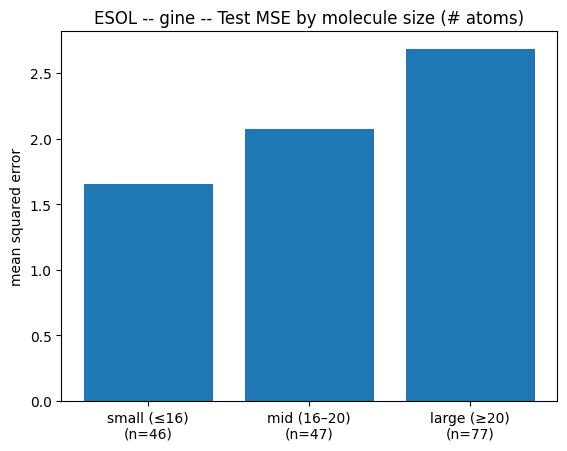

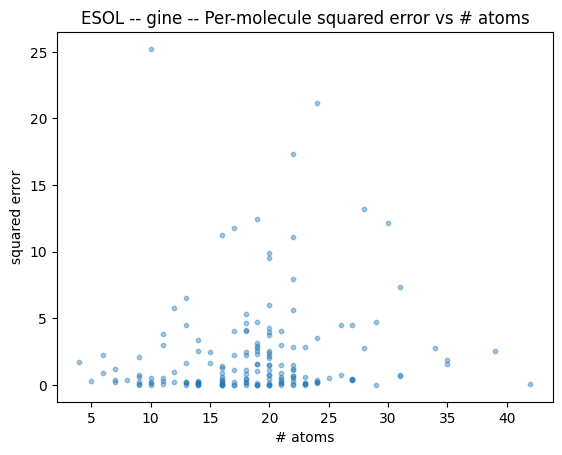

In [14]:
#ERROR PER MOLECULE SIZE AND BY # ATOMS
import matplotlib.pyplot as plt

@torch.no_grad()
def per_graph_se_and_size(model, loader):
    model.eval()
    sizes, ses = [], [] #ses is a concatination of se (squared error)
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch).view(-1)
        y = batch.y.view(-1).to(pred.dtype)

        se = (pred - y).pow(2).detach().cpu().numpy()
        # sz = size
        sz = torch.bincount(batch.batch).detach().cpu().numpy() #atoms per graph
        sizes.append(sz)
        ses.append(se)
    return np.concatenate(sizes), np.concatenate(ses)

sizes, ses = per_graph_se_and_size(model, test_loader)

# 3 bins by quantiles (small/medium/large)
q1, q2 = np.quantile(sizes, [0.33, 0.66])
bins = np.array([sizes.min(), q1, q2, sizes.max() + 1e-9])

labels = [f"small (≤{int(q1)})", f"mid ({int(q1)}–{int(q2)})", f"large (≥{int(q2)})"]
means = []
counts = []

for i in range(3):
    mask = (sizes >= bins[i]) & (sizes < bins[i+1])
    means.append(float(ses[mask].mean()))
    counts.append(int(mask.sum()))

plt.figure()
plt.bar(range(3), means)
plt.xticks(range(3), [f"{labels[i]}\n(n={counts[i]})" for i in range(3)])
plt.title(f"ESOL -- {model_name} -- Test MSE by molecule size (# atoms)")
plt.ylabel("mean squared error")
plt.show()

plt.figure()
plt.scatter(sizes, ses, s=10, alpha=0.4)
plt.title(f"ESOL -- {model_name} -- Per-molecule squared error vs # atoms")
plt.xlabel("# atoms")
plt.ylabel("squared error")
plt.show()


In [15]:
#PREDICTING SOLUBILTY GIVEN SMILES
#FRO_SMILE_CELL 1, ESTABLISHING ALLOWED ELEMENTS AND CONFIDENCE SIZE BAND
from rdkit import Chem
import numpy as np

# Allowed elements = whatever appears in ESOL (by atomic number)
allowed_atomic_nums = set()
bad = 0
for smi in dataset.smiles:
    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        bad += 1
        continue
    for a in mol.GetAtoms():
        allowed_atomic_nums.add(a.GetAtomicNum())

print("RDKit parse failures in ESOL smiles:", bad)
print("Allowed atomic numbers:", sorted(list(allowed_atomic_nums)))
print({6: "Carbon (C)", 7: "Nitrogen (N)", 8: "Oxygen (O)", 9: "Fluorine (F)",
       15: "Phosphorus (P)", 16: "Sulfur (S)", 17: "Chlorine (Cl)",
       35: "Bromine (Br)", 53: "Iodine (I)"})


# Confidence size band from TRAIN molecules (use existing train_idx from scaffold split cell)
train_sizes = np.array([dataset[i].num_nodes for i in train_idx])
lo, hi = np.quantile(train_sizes, [0.05, 0.95])
print(f"Train atom-count band (5%–95%): {lo:.0f} – {hi:.0f}")


RDKit parse failures in ESOL smiles: 0
Allowed atomic numbers: [6, 7, 8, 9, 15, 16, 17, 35, 53]
{6: 'Carbon (C)', 7: 'Nitrogen (N)', 8: 'Oxygen (O)', 9: 'Fluorine (F)', 15: 'Phosphorus (P)', 16: 'Sulfur (S)', 17: 'Chlorine (Cl)', 35: 'Bromine (Br)', 53: 'Iodine (I)'}
Train atom-count band (5%–95%): 4 – 24


In [16]:
# VALIDATING SMILES (USING TESTS). FIGURING OUT HOW TO CONVERT SMILES NOTATION
# TO GRAPHS AND NODES. CALLING MODEL TO PREDICT SOLUBILITY
#FROM_SMILE_CELL 2
import torch
from rdkit import Chem
from torch_geometric.utils import from_smiles
from torch_geometric.data import Batch

MAX_ATOMS = 200

def validate_smiles(smi: str):
    if not isinstance(smi, str) or len(smi.strip()) == 0:
        return False, "empty input", None

    mol = Chem.MolFromSmiles(smi)
    if mol is None:
        return False, "invalid SMILES (RDKit failed to parse)", None

    n_atoms = mol.GetNumAtoms()
    if n_atoms == 0:
        return False, "empty molecule (0 atoms)", None
    if n_atoms > MAX_ATOMS:
        return False, f"too large: {n_atoms} atoms (> {MAX_ATOMS})", None

    for a in mol.GetAtoms():
        z = a.GetAtomicNum()
        if z not in allowed_atomic_nums:
            return False, f"element not in ESOL: atomic_num={z}", None

    return True, "ok", mol

def smiles_to_pyg(smi: str):
    # Graph availability check happens here using dimension matching
    data = from_smiles(smi)
    data.x = data.x.float()
    if getattr(data, "edge_attr", None) is not None:
        data.edge_attr = data.edge_attr.float()
    data.edge_index = data.edge_index.long()

    if data.x.size(-1) != dataset.num_features:
        raise ValueError(f"x dim mismatch: got {data.x.size(-1)} vs ESOL {dataset.num_features}")
    esol_edge_dim = dataset[0].edge_attr.size(-1) if dataset[0].edge_attr is not None else None
    if esol_edge_dim is not None:
        if data.edge_attr is None or data.edge_attr.size(-1) != esol_edge_dim:
            got = None if data.edge_attr is None else data.edge_attr.size(-1)
            raise ValueError(f"edge_attr dim mismatch: got {got} vs ESOL {esol_edge_dim}")

    return data

@torch.no_grad()
def predict_ESOL(smi: str):
    ok, msg, mol = validate_smiles(smi)
    if not ok:
        return None, f"Rejected: {msg}"

    data = smiles_to_pyg(smi)
    batch = Batch.from_data_list([data]).to(device)

    model.eval()
    pred = model(batch).item()

    # Confidence warning based on atom count (5–95%)
    n = data.num_nodes
    warn = ""
    if n < lo or n > hi:
        warn = f" size-warning: {n} atoms is outside train 5–95% band ({lo:.0f}–{hi:.0f})"

    return f"solubilty--> {pred}", f"OK ({n} atoms).{warn}"

# Quick tests
tests = ["CCO", "c1ccccc1", "not_a_smiles"]
for smi in tests:
    yhat, info = predict_ESOL(smi)
    print(smi, "->", yhat, "<-->", info)


CCO -> solubilty--> 1.2225451469421387 <--> OK (3 atoms). size-warning: 3 atoms is outside train 5–95% band (4–24)
c1ccccc1 -> solubilty--> -0.44719985127449036 <--> OK (6 atoms).
not_a_smiles -> None <--> Rejected: invalid SMILES (RDKit failed to parse)


In [17]:
#SOLUBILITY GIVEN SMILES.
#try mannitol OCC(O)C(O)C(O)C(O)CO
my_molecule = input("input_smile:: ")
predict_ESOL(my_molecule)

KeyboardInterrupt: Interrupted by user